# BERTopic Analysis

This Jupyter notebook consists of exploratory code which aims to interpret the resulting dataframe output by sbert.py. The following code looks mainly at the embeddings, topics, topic labels and probabilities attached to the processed EPA comments and makes visualizations which are stored in the folder 'outputs'.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Load the DataFrame
df = pd.read_pickle("../data/df_final.pkl")

# Remove topic -1, as it just consists of noise
df = df[df["topic"] != -1].copy()

In [3]:
print(df.columns)

Index(['processed_comment', 'commentId', 'docketId', 'documentId',
       'postedDate', 'agency', 'embedding', 'topic', 'probability',
       'topic_label', 'sentiment_score', 'sentiment_label', 'sentiment_text',
       'date', 'month'],
      dtype='object')


In [17]:
# Step 1: Convert postedDate → datetime and extract month
df["date"] = pd.to_datetime(df["postedDate"])
df["month"] = df["date"].dt.to_period("M")

# Step 2: Get top N most common topics
top_topics = df["topic_label"].value_counts().head(10).index

# Step 3: Filter to only top topics
filtered_df = df[df["topic_label"].isin(top_topics)].copy()

/tmp/ipykernel_428913/2835929092.py:3: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



### 1. Time-series visualization of frequency of top 10 topic trends

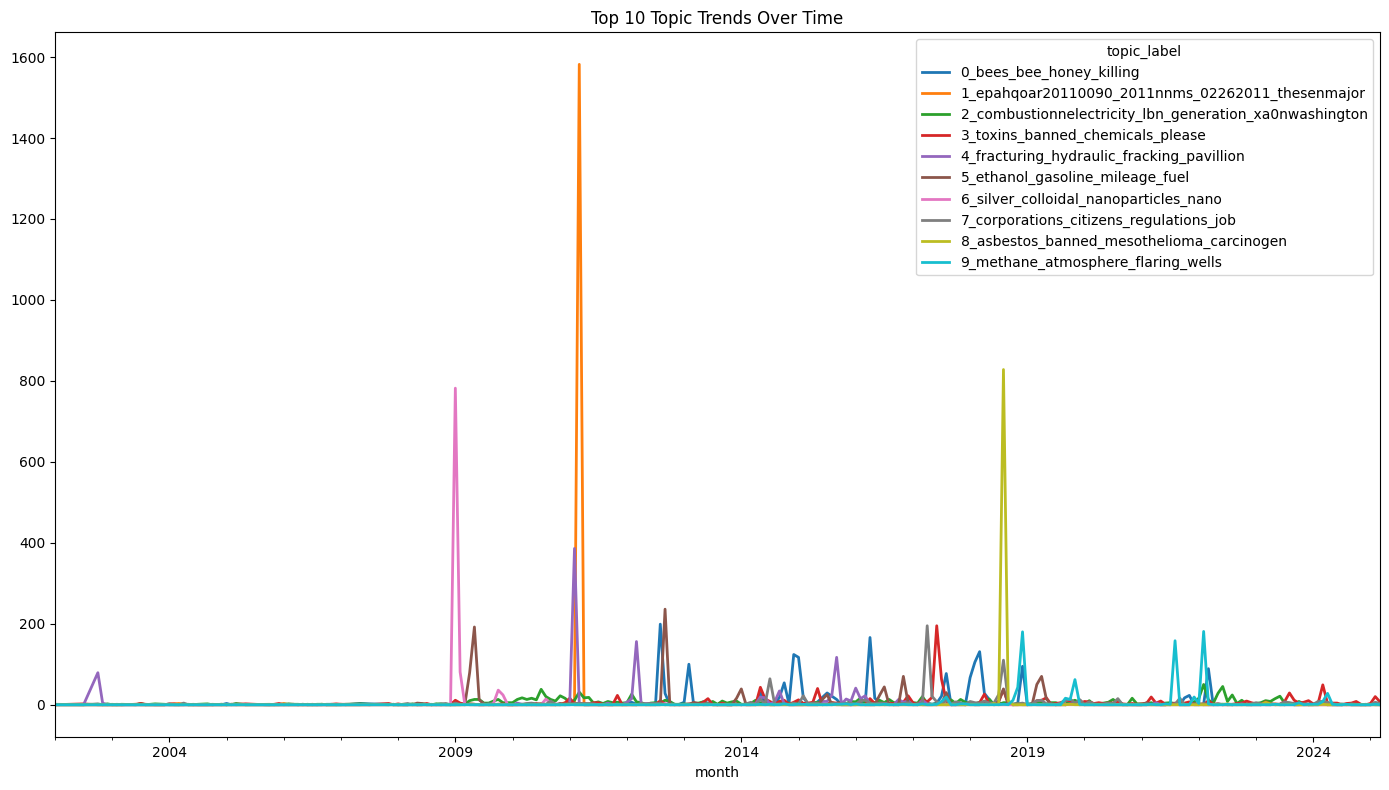

In [18]:
# Step 4: Group and plot
filtered_trends = (
    filtered_df.groupby(["month", "topic_label"])
    .size()
    .unstack(fill_value=0)
)

filtered_trends.plot(
    kind="line",
    figsize=(14, 8),
    linewidth=2,
    title="Top 10 Topic Trends Over Time"
)
# Save the figure
plt.tight_layout()
plt.savefig("../outputs/time_topictrend.png", dpi=300)
plt.show()

To figure out the docket of the orange spike, we can run the following code to figure out docketID where the topic most appears on.

In [5]:
# Target topic label from the spike
target_topic_label = "1_epahqoar20110090_2011nnms_02262011_thesenmajor"

# Filter rows for that topic
df_topic = df[df["topic_label"] == target_topic_label]

# Show the most common docket IDs
print(df_topic["docketId"].value_counts().head(5))

docketId
EPA-HQ-OAR-2011-0089    961
EPA-HQ-OAR-2011-0090    621
EPA-HQ-OGC-2010-1045      7
EPA-HQ-OAR-2021-0317      5
EPA-HQ-OAR-2003-0053      4
Name: count, dtype: int64


[Docket EPA-HQ-OAR-2011-0089](https://www.regulations.gov/docket/EPA-HQ-OAR-2011-0089) and [Docket EPA-HQ-OAR-2011-0090](https://www.regulations.gov/docket/EPA-HQ-OAR-2011-0090) talk about the Oil and Natural Gas sector. The documents under these review updating pollution standards and limit of hazardous air pollutants.

### 2. Silhouette Score

The silhouette score will tell us the quality of clustering of data points by considering cohesion and separation. It ranges from -1 to 1, where a score close to +1 suggests well-defined clusters and -1 means wrong clustering.

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X = np.vstack(df["embedding"].values)
labels = df["topic"].values
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.086


Our score being around 0.1 suggests that topics and messy and tend to overlap a lot.

### 3. Top 20 topics and the amount of comments under them

/tmp/ipykernel_428913/3426070426.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




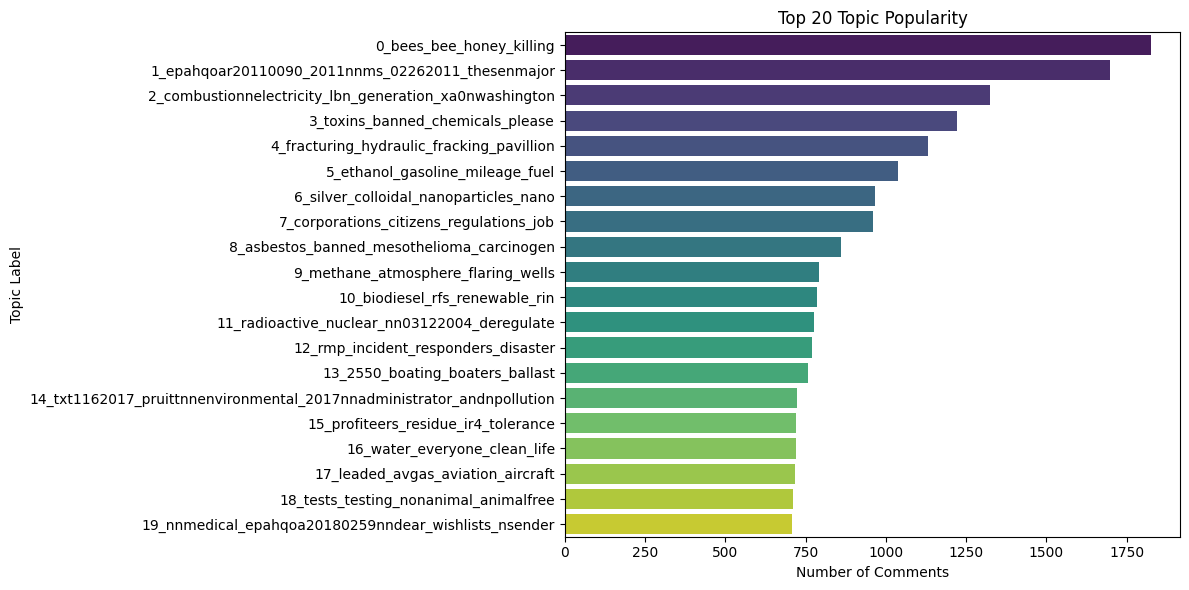

In [19]:
# Get top 20 topic labels
topic_counts = df["topic_label"].value_counts().head(20)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")
plt.xlabel("Number of Comments")
plt.ylabel("Topic Label")
plt.title("Top 20 Topic Popularity")
plt.tight_layout()
plt.savefig("../outputs/top20_topic_count.png", dpi=300)
plt.show()
